### Importando las librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
xScaler = MinMaxScaler()

In [3]:
def aMatrix(X, p):
    Xfinal = np.ones((X.shape[0],1))
    for i in range(1,p+1):
        Xfinal = np.append(Xfinal,X**i, axis=1)
    return np.array(Xfinal)

### Preparacion de datos

In [4]:
data = pd.read_csv("data/forestfires.csv")

<AxesSubplot:>

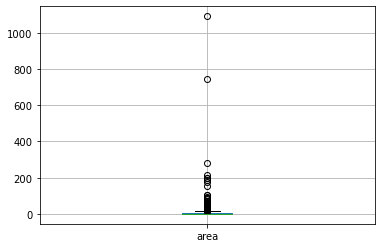

In [5]:
data.boxplot(column=['area'])

In [6]:
# se removeran valores muy atipicos para el entrenamiento
data = data.loc[data["area"] < 250]
xprep = data.iloc[:,0:12]
yprep = data.iloc[:,12]

<AxesSubplot:>

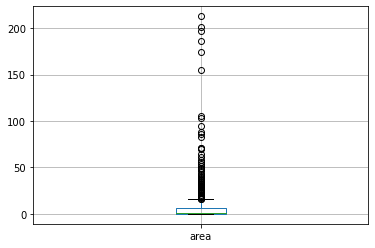

In [7]:
data.boxplot(column=['area'])

In [8]:
# Para otras pruebas se consideran solo las variables numericas.
xprepNoCat = data.loc[:,['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind', 'rain']]

In [9]:
# Creamos las variables "dummy" para las variables categoricas
def create_dummy(listCategorical, df, columnCat):
    for category in listCategorical:
        df[category] = np.where(df.loc[:,columnCat] == category, 1, 0)
    return df

In [10]:
listMonth = list(xprep.loc[:,"month"].unique())
listDay = list(xprep.loc[:,"day"].unique())
xprep = create_dummy(listMonth, xprep, "month")
xprep = create_dummy(listDay, xprep, "day")

In [11]:
xprep.drop('month', inplace=True, axis=1)
xprep.drop('day', inplace=True, axis=1)

In [12]:
# los datos X: incluye las categoricas / XNoCat: excluye a las categoricas
X = xprep.to_numpy()
XNoCat = xprepNoCat.to_numpy()
y  = np.array([yprep]).T

In [13]:
# los datos normalizados
Xnorm = xScaler.fit_transform(X)
XnormNoCat = xScaler.fit_transform(XNoCat)

### Sepracion de datos para entrenamiento y test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(XnormNoCat, y, test_size=0.1, random_state=42)
print(X_train.shape)

(462, 10)


#### Funciones para calcular

In [15]:
def h(X, W):
    return X.dot(W)

In [16]:
def update(W,  dW, alpha):
    W  = W - alpha*dW
    return W

In [17]:
def Error(X, W, Y, lambd = 0.1, rho=0.5 , errtype="MSE", tipoReg="Lineal"):
    outError1 = 0
    contribucion = 0
    if errtype == "MSE":
        outError = np.sum(((h(X,W)-Y)**2), axis=0)[0]/(2*Y.shape[0])
    elif errtype == "MAE":
        outError  = np.sum(abs(h(X,W) - Y))/Y.shape[0]
    else:
        print("Tipo de error no definido")
    
    if tipoReg == "Lineal":
        contribucion = 0
    elif tipoReg == "Lasso":
        contribucion = lamb * np.sum(W,axis=0)[0]
    elif tipoReg == "Ridge":
        contribucion = lamb * np.sum(W**2,axis=0)[0]
    elif tipoReg == "Elastinet":
        contribucion = rho*lambd*np.sum(np.abs(W),axis=0)[0] + 0.5*(1-rho)*lambd*np.sum(W**2,axis=0)[0]
    else:
        print("Tipo de regresion no definido")
        
    return outError + contribucion

In [18]:
def derivada(X, W, Y, lambd = 0.1, rho= 0.5, errtype="MSE", tipoReg="Lineal"):
    outderivada = 0
    contribucion = 0
    
    if errtype == "MSE":
        outderivada = 1/Y.shape[0]*np.sum((h(X,W)-Y)*X,axis=0).reshape(-1,1)
    elif errtype == "MAE":
        temp = np.sign(h(X,W) - Y)
        outderivada = 1/Y.shape[0]*np.sum((temp)*X,axis=0).reshape(-1,1)
    else: 
        print("Tipo de error no definido")
    
    if tipoReg == "Lineal":
        contribucion = 0
    elif tipoReg == "Lasso":
        contribucion = (lambd * np.sign(W))
    elif tipoReg == "Ridge":
        contribucion = (2 * lambd * W)
    elif tipoReg == "Elastinet":
        contribucion = rho*(lambd*np.sign(W))  + (1*(1-rho)*lambd*W)
    else:
        print("Tipo de regresion no definida")
        
    return outderivada + contribucion

In [19]:
def trainall(X, Y, epoch, alfa, p = 1, lambd=0.1, rho =0.5, errtype="MSE", tipoReg = "Lineal"):
    if tipoReg == "Lineal":
        Xin = np.insert(X, 0,1, axis = 1)
        Win = np.random.rand(X.shape[1]+1).reshape((X.shape[1]+1,1))
    else:
        Xin = aMatrix(X,p)
        Win = np.random.rand(X.shape[1]*p+1).reshape((X.shape[1]*p+1,1))
    L = Error(Xin, Win, Y, lambd, rho, errtype, tipoReg)
    loss = []
    contador = 0;
    while (epoch > contador):
        dW = derivada(Xin, Win, Y, lambd, rho, errtype, tipoReg)
        Win = update(Win, alfa, dW)
        L = Error(Xin, Win, Y, lambd, rho, errtype, tipoReg)
        loss.append(L)
        epochs = len(loss)
        contador = contador + 1
    return Win, loss, epochs  

Se realizó en: 10000 epocas
Con un error de: 325.9686726925462


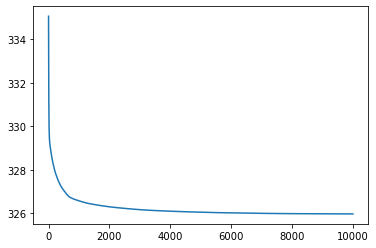

In [36]:
errtypein = "MSE"
tipoReg = "Elastinet"
epocas = 10000
alpha = 0.01
p = 4
lamb1= 0.1    # 0.1
rhoIn = 0.9        # 0.9
W_R, loss_R, epochs_R = trainall(X_train, y_train, epocas,  alpha, p, lamb1, rhoIn, errtypein, tipoReg)
print(f'Se realizó en: {epochs_R} epocas')
print(f'Con un error de: {min(loss_R)}')
plt.plot(loss_R)

In [40]:
min(loss_R)

336.85195666459043

In [43]:
listaIter = [100, 500, 1000, 10000]
listaAlphas = [0.9,0.7,0.3, 0.2, 0.1,0.01,0.001,0.000]

listaparams = []

tipoReg = "Lineal"

tipoerror = "MAE"
for cant in listaIter:
    epocas = cant
    for alp in listaAlphas:
        alpha = alp
        W_R, loss_R, epochs_R = trainall(X_train, y_train, epocas,  alpha, p, lamb1, rhoIn, tipoerror, tipoReg)
        listaparams.append([cant, alp, min(loss_R)])

In [44]:
listaparams

[[100, 0.9, 9.315161598755733],
 [100, 0.7, 9.27933476854517],
 [100, 0.3, 9.235244660292844],
 [100, 0.2, 9.222673145142306],
 [100, 0.1, 9.222346541382041],
 [100, 0.01, 10.906118387068247],
 [100, 0.001, 12.338367776881224],
 [100, 0.0, 12.9708178645667],
 [500, 0.9, 9.310858745034755],
 [500, 0.7, 9.279209992136895],
 [500, 0.3, 9.232190950013658],
 [500, 0.2, 9.220815362695932],
 [500, 0.1, 9.208322356155051],
 [500, 0.01, 9.473174179549181],
 [500, 0.001, 10.667988409029876],
 [500, 0.0, 12.440489453584192],
 [1000, 0.9, 9.290566979584913],
 [1000, 0.7, 9.275997339062975],
 [1000, 0.3, 9.230908208039049],
 [1000, 0.2, 9.218467205026734],
 [1000, 0.1, 9.209598251899106],
 [1000, 0.01, 9.200951749555147],
 [1000, 0.001, 10.767626086328987],
 [1000, 0.0, 13.196989332218848],
 [10000, 0.9, 9.295634501812787],
 [10000, 0.7, 9.26876222444737],
 [10000, 0.3, 9.227935180960246],
 [10000, 0.2, 9.218131332468117],
 [10000, 0.1, 9.208571555085854],
 [10000, 0.01, 9.199786162209875],
 [10000

In [54]:
def prediccion_error(xtest, ytest, wfinal, tipoReg, p, tipoErr)
    if tipo == "Lineal":
        Xinpred = np.insert(xtest,0,1, axis = 1)
    else:
        Xinpred = aMatrix(X_test,p)

    predict = Xinpred.dot(wfinal)
    
    if tipoErr == "MSE":
        error = np.sum(((h(X,W)-Y)**2), axis=0)[0]/(2*Y.shape[0])
      
    return 

In [22]:
W_R.shape

(41, 1)

In [23]:
pred1 = aMatrix(X_test, 4).dot(W_R)

In [24]:
pred1

array([[ 8.45086848],
       [12.63562422],
       [ 4.54021408],
       [ 8.70260462],
       [ 8.83529485],
       [ 4.94577136],
       [ 4.83643082],
       [12.27706593],
       [ 9.97448461],
       [14.12245729],
       [ 8.61278263],
       [10.634866  ],
       [ 7.63550243],
       [ 9.03863962],
       [10.03311437],
       [ 9.99938977],
       [ 7.15781096],
       [10.25860981],
       [12.70843591],
       [ 9.44717018],
       [ 5.12120245],
       [12.67993878],
       [ 6.00882617],
       [ 9.93792768],
       [ 8.34476631],
       [13.50970965],
       [10.78984415],
       [15.00807007],
       [12.59321264],
       [ 8.08600655],
       [10.52727235],
       [ 9.34987321],
       [ 9.44953107],
       [10.76634504],
       [ 5.82997673],
       [13.61006095],
       [ 8.54481077],
       [ 9.96682255],
       [ 9.08884472],
       [ 8.50363804],
       [13.53186285],
       [ 9.25676959],
       [10.19502063],
       [10.45257603],
       [11.47998798],
       [ 3

In [25]:
y_test

array([[ 0.  ],
       [ 0.  ],
       [ 3.35],
       [ 1.46],
       [ 0.  ],
       [ 0.  ],
       [13.99],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 2.93],
       [ 1.72],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 6.96],
       [10.02],
       [36.85],
       [23.41],
       [ 0.  ],
       [19.23],
       [ 0.  ],
       [ 0.24],
       [ 0.  ],
       [ 5.86],
       [ 2.18],
       [ 4.42],
       [ 0.76],
       [11.22],
       [ 0.47],
       [ 0.  ],
       [ 0.  ],
       [ 8.16],
       [ 0.  ],
       [48.55],
       [ 0.  ],
       [ 4.69],
       [ 0.  ],
       [ 0.  ],
       [ 1.56],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [ 0.  ],
       [61.13],
       [ 0.  ],
       [ 7.36],
       [ 0.  ],
       [ 0.  ]])

In [30]:
tempot = np.sum(abs(pred1 - y_test), axis = 0)[0]/(2*y_test.shape[0])

In [31]:
dere = np.sum((pred1 - y_test)**2, axis = 0)[0]/(2*y_test.shape[0])

In [32]:
tempot

5.007116603961039

In [33]:
dere

89.32590471287398

In [34]:
y_test.shape[0]

52

In [31]:
from sklearn.metrics import r2_score
r2_score(y, y_predict)

0.021189706317142454

Testing Sklearn Elastic Net

In [30]:
from sklearn.linear_model import ElasticNet


In [34]:
regr = ElasticNet(random_state=0)
regr.fit(X, y)
ElasticNet(random_state=0)
print(regr.coef_)

print(regr.intercept_)

print(regr.predict([X[516]]))

[ 1.69061703  0.30874544 -0.0496184   0.0860993  -0.00642681 -0.5700025
  0.69845019 -0.24004841  1.16070768 -0.         -0.         -0.
 -0.79999577  1.71605858  0.         -0.         -0.          0.
  0.          0.          0.         -0.         -0.81347779  0.
  2.23603607 -0.         -0.         -0.          0.        ]
[-0.4995132]
[11.59471296]


In [32]:
X[0]

array([ 7. ,  5. , 86.2, 26.2, 94.3,  5.1,  8.2, 51. ,  6.7,  0. ,  1. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

In [33]:
X.shape

(517, 29)